Estão sendo apurado os retornos mesnais, mas o mesmo mesmos estão sendo anualizado. Portanto a taxa livre de risco é infomada de forma anual.

# Validação

Site pra validar dados mensais

https://portfoliometrics.net/optimization

https://valueinvesting.io/efficient-frontier?utm_source=chatgpt.com

https://www.portfoliovisualizer.com/optimize-portfolio#analysisResults

jan/2020 a dez 2024

GOOG - Alphabet Inc 31.65%

MSFT - Microsoft Corp 56.31%

NFLX - Netflix Inc 12.04%

Expected Return 24.54%

Standard Deviation	22.43%

Sharpe Ratio 0.90


# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [92]:
def best_portfolio(wallets, method = 'sharpe_ratio'):
    vol = wallets['riscos']
    sharpe = wallets['sharpes']
    weights = wallets['pesos']
    returns = wallets['retornos']

    if method == 'sharpe_ratio':
        indice = np.array(sharpe).argmax()

    elif method == 'volatility':
        indice = np.array(vol).argmin()

    elif method == 'return':
        indice = np.array(returns).argmax()

    return weights[indice], returns[indice], vol[indice]

def plot_efficient_frontier(carteiras, method = 'sharpe_ratio', rf=0.0):
    banda=0.1

    riscos, retornos, sharpe= carteiras['riscos'], carteiras['retornos'], carteiras['sharpes']

    if method == 'sharpe_ratio':
        indice = np.array(sharpe).argmax()
    elif method == 'volatility':
        indice = np.array(riscos).argmin()
    elif method == 'return':
        indice = np.array(retornos).argmax()
    else:
       raise ValueError("method deve ser 'sharpe_ratio', 'volatility' ou 'return'")

    X_axis = riscos[indice]
    y_axis = retornos[indice]

    #plota espalhamento
    sc = plt.scatter(riscos, retornos, c = sharpe, cmap = 'viridis')
    plt.colorbar(sc, label='Sharpe Ratio')
    #plota sharpe
    plt.scatter(X_axis, y_axis, c = 'red', s = 50,label='Portfólio Ótimo')

    # plota a LAC
    slope = (y_axis - rf) / X_axis  # Sharpe ratio do portfólio ótimo
    sigma_line = np.linspace(0, max(riscos)*1.1, 100)
    R_line = rf + slope * sigma_line
    plt.plot(sigma_line, R_line, color='orange', linestyle='--', label='CAL')

    # ajustar limite dinamicamente
    def ajustar_limites(valores, banda):
        min_val, max_val = min(valores), max(valores)
        faixa = max(valores) - min(valores)
        return min_val - faixa*banda, max_val + faixa*banda

    x_min, x_max = ajustar_limites(riscos, banda)
    y_min, y_max = ajustar_limites(retornos, banda)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    #plotar
    plt.title("Fronteira Eficiente")
    plt.xlabel("risco")
    plt.ylabel("retorno")
    plt.legend()
    plt.show()

def fn_busca_selic_media_anual(dt_ini, dt_fim):
    # Taxa SELIC Mensal (% a.a.)
  dt_ini_fmt = pd.to_datetime(dt_ini).strftime('%d/%m/%Y')
  dt_fim_fmt = pd.to_datetime(dt_fim).strftime('%d/%m/%Y')
  url = ( "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados" f"?formato=json&dataInicial={dt_ini_fmt}&dataFinal={dt_fim_fmt}")
  selic = pd.read_json(url)
  # Converte a coluna de data
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  #selic['valor'] = pd.to_numeric(selic['valor'])
  selic_media_anual = selic['valor'].mean() + 12
  return selic_media_anual

# Corpo principal

Parametros

In [81]:
# ******************************** PARAMETROS *******************************
tickers = ['AMZN', 'GOOG', 'MSFT', 'NFLX']
#tickers = ['PRIO3.SA','JHSF3.SA','ODPV3.SA','ITSA4.SA', 'EGIE3.SA' ,'LREN3.SA' ,'FLRY3.SA' ,'TRIS3.SA','SBFG3.SA',           'BBAS3.SA' ,'VALE3.SA' ,'ALOS3.SA','KLBN4.SA','CSAN3.SA','IVVB11.SA']

dt_ini, dt_fim =  '2020-01-01','2024-01-01'
#dt_ini, dt_fim =  '2024-01-01','2025-07-01'
num_portfolios=10000
risk_free = fn_busca_selic_media_anual(dt_ini, dt_fim)

# ******************************** PRECOS *******************************
df_precos = pd.DataFrame()
df_precos = yf.download(tickers,  dt_ini, dt_fim)['Close']
df_precos = df_precos.resample('M').last()

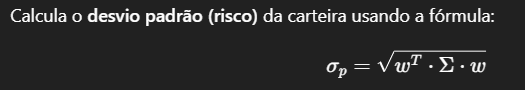


In [83]:
# ******************************** CARTEIRAS *******************************
pesos = []
retornos = []
riscos = []
sharpes = []

df_retornos = df_precos.pct_change()
df_retornos_medios = df_retornos.mean() * 12 # retorno anualizado

# matriz de covariância
mat_covarianca = np.cov(df_retornos[1:].T)

for i in range(num_portfolios):
    # gerando pesos aleatórios
    k = np.random.rand(len(df_precos.columns))
    w = k / sum (k)

    retorno = np.dot(df_retornos_medios, w)

    risco = np.sqrt(np.dot(w.T, np.dot(mat_covarianca, w))) * np.sqrt(12) #risco anualizado

    # sharpe ratio
    sharpe = (retorno - risk_free)/risco

    pesos.append(w)
    retornos.append(retorno)
    riscos.append(risco)
    sharpes.append(sharpe)

carteiras = {'pesos': pesos,
          'retornos': retornos,
          'riscos':riscos,
          'sharpes': sharpes}

In [95]:
# ************************* MELHORES PORTFOLIOS ****************************
def exibir(titulo, estrategia):
  print('\n' + titulo)
  print('Risco(%): ' , round(estrategia['risco'] *100 ,2))
  print('Retorno(%): ' , round(estrategia['retorno']*100,2))
  print('Sharpe: ' , round(estrategia['sharpe'],2))
  pesos = estrategia['pesos'].tolist()
  duplas_ordenadas = sorted(zip(tickers, pesos), key=lambda x: x[0])
  for t, p in duplas_ordenadas:
    print(t,': ', round(p *100,2))

# MELHOR PORTFOLIO
risco = carteiras['riscos']
sharpe = carteiras['sharpes']
weights = carteiras['pesos']
retornos = carteiras['retornos']

ind_sharpe = np.array(sharpe).argmax()
ind_risco = np.array(risco).argmin()
ind_retornos = np.array(retornos).argmax()

resultado = {
    "sharpe_ratio": {
        "risco": risco[ind_sharpe],
        "sharpe": sharpe[ind_sharpe],
        "retorno": retornos[ind_sharpe],
        'pesos': weights[ind_sharpe]

    },
    "risco": {
        "risco": risco[ind_risco],
        "sharpe": sharpe[ind_risco],
        "retorno": retornos[ind_risco],
        'pesos': weights[ind_risco]
    },
    "retorno": {
        "risco": risco[ind_retornos],
        "sharpe": sharpe[ind_retornos],
        "retorno": retornos[ind_retornos],
        'pesos': weights[ind_retornos]
    },
}

exibir('--- Estratégia: Melhor Sharpe --- ', resultado['sharpe_ratio'] )
exibir('--- Estratégia: Menor risco --- ', resultado['risco'] )
exibir('--- Estratégia: Maior retorno --- ', resultado['retorno'] )


--- Estratégia: Melhor Sharpe --- 
Risco(%):  16.96
Retorno(%):  19.73
Sharpe:  0.28
ALOS3.SA :  4.84
BBAS3.SA :  6.5
CSAN3.SA :  17.25
EGIE3.SA :  0.2
FLRY3.SA :  10.65
ITSA4.SA :  16.28
IVVB11.SA :  2.79
JHSF3.SA :  1.11
KLBN4.SA :  6.4
LREN3.SA :  10.49
ODPV3.SA :  0.37
PRIO3.SA :  7.76
SBFG3.SA :  1.04
TRIS3.SA :  6.86
VALE3.SA :  7.45

--- Estratégia: Menor risco --- 
Risco(%):  8.31
Retorno(%):  4.13
Sharpe:  -1.31
ALOS3.SA :  3.6
BBAS3.SA :  0.6
CSAN3.SA :  2.13
EGIE3.SA :  11.61
FLRY3.SA :  17.64
ITSA4.SA :  3.12
IVVB11.SA :  5.63
JHSF3.SA :  19.63
KLBN4.SA :  0.13
LREN3.SA :  0.32
ODPV3.SA :  2.84
PRIO3.SA :  4.74
SBFG3.SA :  8.4
TRIS3.SA :  2.52
VALE3.SA :  17.09

--- Estratégia: Maior retorno --- 
Risco(%):  16.96
Retorno(%):  19.73
Sharpe:  0.28
ALOS3.SA :  4.84
BBAS3.SA :  6.5
CSAN3.SA :  17.25
EGIE3.SA :  0.2
FLRY3.SA :  10.65
ITSA4.SA :  16.28
IVVB11.SA :  2.79
JHSF3.SA :  1.11
KLBN4.SA :  6.4
LREN3.SA :  10.49
ODPV3.SA :  0.37
PRIO3.SA :  7.76
SBFG3.SA :  1.04
TRIS3.SA

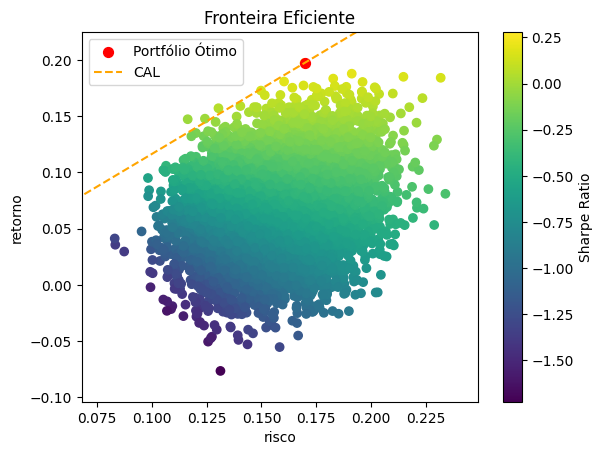

In [85]:
plot_efficient_frontier(carteiras, method = 'sharpe_ratio')

# Execução completa

/tmp/ipython-input-2923618486.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_precos = yf.download(tickers,  "2020-01-01", "2024-12-31")['Close']
[*********************100%***********************]  4 of 4 completed
/tmp/ipython-input-2923618486.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_precos = df_precos.resample('M').last()



Melhor Sharpe
Risco(%):  37.05
Retorno(%):  32.54
Sharpe:  0.61
Pesos(%):  [4.96, 7.91, 0.6, 86.53]

Menor risco
Risco(%):  20.07
Retorno(%):  3.4
Sharpe:  -0.33
Pesos(%):  [81.7, 8.57, 0.97, 8.75]

Maior retorno
Risco(%):  37.05
Retorno(%):  32.54
Sharpe:  0.61
Pesos(%):  [4.96, 7.91, 0.6, 86.53]


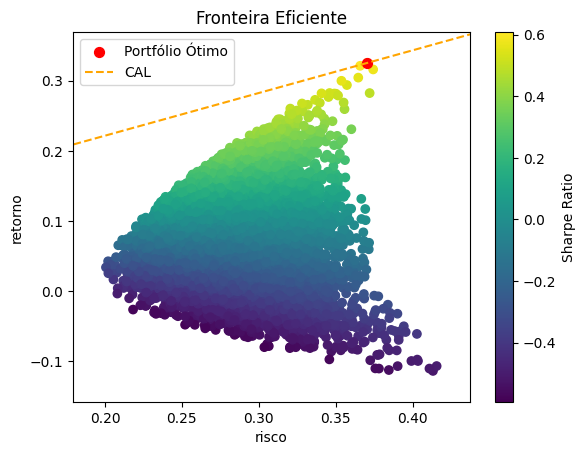

In [ ]:
# Montando o nossa carteira
#tickers = ['AMZN', 'GOOG', 'MSFT', 'NFLX']
tickers = ['ITSA4.SA', 'EGIE3.SA', 'LREN3.SA', 'PETR4.SA']

num_portfolios=10000
risk_free = .10

#preços mensais
df_precos = pd.DataFrame()
df_precos = yf.download(tickers,  "2020-01-01", "2024-12-31")['Close']
df_precos = df_precos.resample('M').last()

pesos = []
retornos = []
riscos = []
sharpes = []

df_retornos = df_precos.pct_change()
df_retornos_medios = df_retornos.mean() * 12 # retorno anualizado

# matriz de covariância
mat_covarianca = np.cov(df_retornos[1:].T)

for i in range(num_portfolios):
    # gerando pesos aleatórios
    k = np.random.rand(len(df_precos.columns))
    w = k / sum (k)

    retorno = np.dot(df_retornos_medios, w)

    risco = np.sqrt(np.dot(w.T, np.dot(mat_covarianca, w))) * np.sqrt(12) #risco anualizado

    # sharpe ratio
    sharpe = (retorno - risk_free)/risco

    pesos.append(w)
    retornos.append(retorno)
    riscos.append(risco)
    sharpes.append(sharpe)

carteiras = {'pesos': pesos,
          'retornos': retornos,
          'riscos':riscos,
          'sharpes': sharpes}

def exibir(titulo, estrategia):
  print('\n' + titulo)
  print('Risco(%): ' , round(estrategia['risco'] *100 ,2))
  print('Retorno(%): ' , round(estrategia['retorno']*100,2))
  print('Sharpe: ' , round(estrategia['sharpe'],2))
  print('Pesos(%): ',  [round(p*100,2) for p in estrategia['pesos'].tolist()])


# MELHOR PORTFOLIO
risco = carteiras['riscos']
sharpe = carteiras['sharpes']
weights = carteiras['pesos']
retornos = carteiras['retornos']

ind_sharpe = np.array(sharpe).argmax()
ind_risco = np.array(risco).argmin()
ind_retornos = np.array(retornos).argmax()

resultado = {
    "sharpe_ratio": {
        "risco": risco[ind_sharpe],
        "sharpe": sharpe[ind_sharpe],
        "retorno": retornos[ind_sharpe],
        'pesos': weights[ind_sharpe]

    },
    "risco": {
        "risco": risco[ind_risco],
        "sharpe": sharpe[ind_risco],
        "retorno": retornos[ind_risco],
        'pesos': weights[ind_risco]
    },
    "retorno": {
        "risco": risco[ind_retornos],
        "sharpe": sharpe[ind_retornos],
        "retorno": retornos[ind_retornos],
        'pesos': weights[ind_retornos]
    },
}

exibir('Melhor Sharpe', resultado['sharpe_ratio'] )
exibir('Menor risco', resultado['risco'] )
exibir('Maior retorno', resultado['retorno'] )

plot_efficient_frontier(carteiras,  'sharpe_ratio',risk_free)